In [1]:
import los
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np

import astropy.units as u
import astropy.constants as c
from astropy.time import Time

from tqdm.autonotebook import tqdm

from astroquery.jplhorizons import Horizons

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/Users/thomassiegert/.virtualenvs/3ml_stuff/lib/python3.7/site-packages/ipykernel_launcher.py:10: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  # Remove the CWD from sys.path while we load stuff.


In [2]:
pixelsize = 1

In [3]:
nfw = los.NFW_Halo_Milky_Way(n=2,frame='G',pixelsize=pixelsize,observer=10)

In [4]:
nfw.los_source()

In [5]:
nfw.J_factor

<Quantity 1.84280826e+22 GeV2 / cm5>

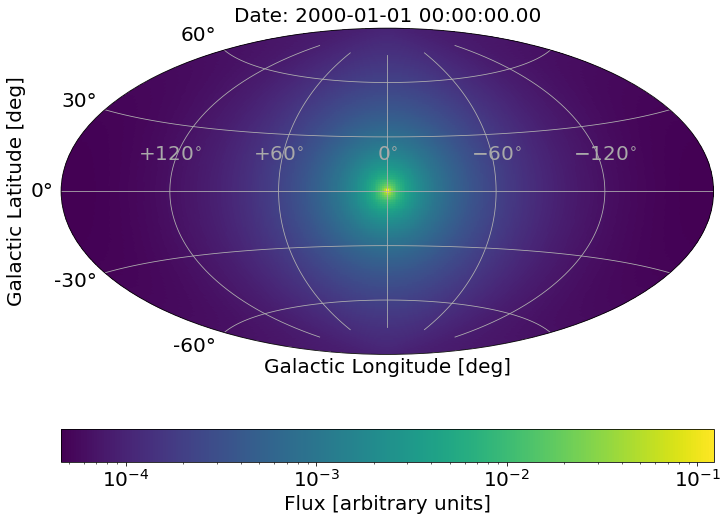

In [6]:
nfw.plot_source(projection='aitoff',norm=colors.LogNorm())

<h3>In these calculations for the NFW halo, the 'flux' is in units of: $\mathrm{M_{\odot}^2/pc^6 \cdot kpc / sr}$, and is calculated by:<br>
    $F = \frac{1}{4\pi\,\mathrm{sr}} \int_{\text{los}} \rho^{2}(\psi, l)\, dl\,\mathrm{,}$<br>
    Thus, for you to get the actual flux at each pixel, you multiply $F$ by<br>
    $\frac{\langle \sigma v \rangle}{2m_{\chi}^{2}} \frac{dN_{a}}{dE}$<br><br>
    Example: pixel value = $0.1\,\mathrm{M_{\odot}^2/pc^6 \cdot kpc / sr}$; $\langle \sigma v \rangle = 10^{-29}\,\mathrm{cm^3/s}$; $m_{\chi} = 1\,\mathrm{TeV}$; $\frac{dN_{a}}{dE}(E_\gamma = 1\,\mathrm{GeV}) = 10^{-11}\,\mathrm{eV^{-1}}$;<br>
    Then we get an actual gamma-ray flux of $0.1\,\mathrm{M_{\odot}^2/pc^6 \cdot kpc / sr} \times 10^{-29}\,\mathrm{cm^3/s} \times \frac{1}{2\,\mathrm{TeV^2}} \times 10^{-11}\,\mathrm{eV^{-1}}$

In [7]:
(0.1 * u.Msun**2 / u.pc**6 * u.kpc / u.sr * 1e-29 * u.cm**3 / u.s / (2*u.TeV**2/c.c**4) * 1e-11 / u.eV).to(1/u.cm**2/u.s/u.sr/u.eV)

<Quantity 2.22377643e-23 1 / (cm2 eV s sr)>

<h3>For the whole image you then just do:</h3>

In [8]:
# extract the image from above:
nfw_image = nfw._image

In [9]:
# extract the coordinates
PHI_ARR, THETA_ARR, PHI_ARRg, THETA_ARRg, dOmega = nfw.coordinates

In [10]:
# 2D array that contains the longitudinal coordinates for each pixel
PHI_ARR.shape

(180, 360)

In [11]:
# 2D array that contains the latitudinal coordinates for each pixel
THETA_ARR.shape

(180, 360)

In [12]:
# contains the boundaries of the pixels
PHI_ARRg.shape

(181, 361)

In [13]:
# 2D array that contains the solid angle of each pixel
dOmega.shape

(180, 360)

In [14]:
# sum of solid angles for all pixel should be equal to 4 pi
np.sum(dOmega),4*np.pi

(12.566370614359165, 12.566370614359172)

In [15]:
nfw_map = (nfw_image * u.Msun**2 / u.pc**6 * u.kpc / u.sr * 1e-29 * u.cm**3 / u.s / (2*u.TeV**2/c.c**4) * 1e-11 / u.eV).to(1/u.cm**2/u.s/u.sr/u.eV)

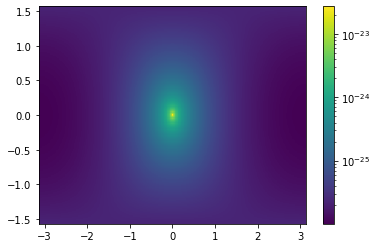

In [16]:
plt.pcolormesh(PHI_ARRg,THETA_ARRg,nfw_map,norm=colors.LogNorm())
plt.colorbar()

<h3>Now that you have a spectrum, $dN/dE(E)$, you need to create a data cube: image vs energy</h3>

In [17]:
# example: energy array from 100 keV to 1 TeV with 100 entries:
n_e = 100
energies = np.geomspace(1e5,1e12,100)*u.eV

In [18]:
# number of phi and theta pixels:
n_theta, n_phi = nfw_image.shape

In [19]:
n_phi, n_theta

(360, 180)

In [20]:
# creating empty array for all images with the correct units already attached
nfw_images_energy = np.zeros((n_e,n_theta,n_phi))/u.cm**2/u.s/u.sr/u.eV

In [21]:
nfw_images_energy.shape

(100, 180, 360)

In [22]:
# I assume a powerlaw spectrum for dN/dE
def dNdE(energies):
    val = (1e-11*(energies/u.GeV)**(-2)/u.eV).to(1/u.eV)
    return val

Text(0, 0.5, 'dN/dE [1/eV]')

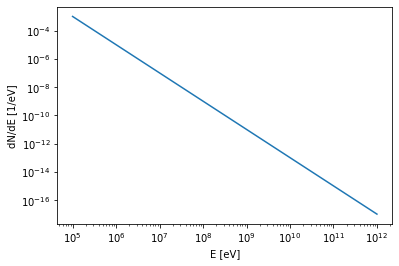

In [23]:
plt.loglog(energies,dNdE(energies))
plt.xlabel('E [eV]')
plt.ylabel('dN/dE [1/eV]')

In [24]:
# dNdE(E=1GeV)
dNdE(1e9*u.eV)

<Quantity 1.e-11 1 / eV>

<h3>In principle, one could do the next step without a for loop, but that's confusing to read, so we loop over the energies and and multiply the thing for each image:</h3>

In [25]:
sigmav = 1e-29 * u.cm**3 / u.s
rho2_unit = u.Msun**2 / u.pc**6 * u.kpc / u.sr
m_chi = 1*u.TeV/c.c**2


for i in range(n_e):
    nfw_images_energy[i,:,:] = (nfw_image * rho2_unit * sigmav / (2*m_chi**2) * dNdE(energies[i])).to(1/u.cm**2/u.s/u.sr/u.eV)

In [26]:
nfw_images_energy[0,:,:]

<Quantity [[2.19970279e-18, 2.19970931e-18, 2.19972234e-18, ...,
            2.19972234e-18, 2.19970931e-18, 2.19970279e-18],
           [2.15769226e-18, 2.15771112e-18, 2.15774883e-18, ...,
            2.15774883e-18, 2.15771112e-18, 2.15769226e-18],
           [2.11716628e-18, 2.11719662e-18, 2.11725728e-18, ...,
            2.11725728e-18, 2.11719662e-18, 2.11716628e-18],
           ...,
           [2.12781327e-18, 2.12784389e-18, 2.12790512e-18, ...,
            2.12790512e-18, 2.12784389e-18, 2.12781327e-18],
           [2.16872813e-18, 2.16874717e-18, 2.16878524e-18, ...,
            2.16878524e-18, 2.16874717e-18, 2.16872813e-18],
           [2.21114497e-18, 2.21115155e-18, 2.21116470e-18, ...,
            2.21116470e-18, 2.21115155e-18, 2.21114497e-18]] 1 / (cm2 eV s sr)>

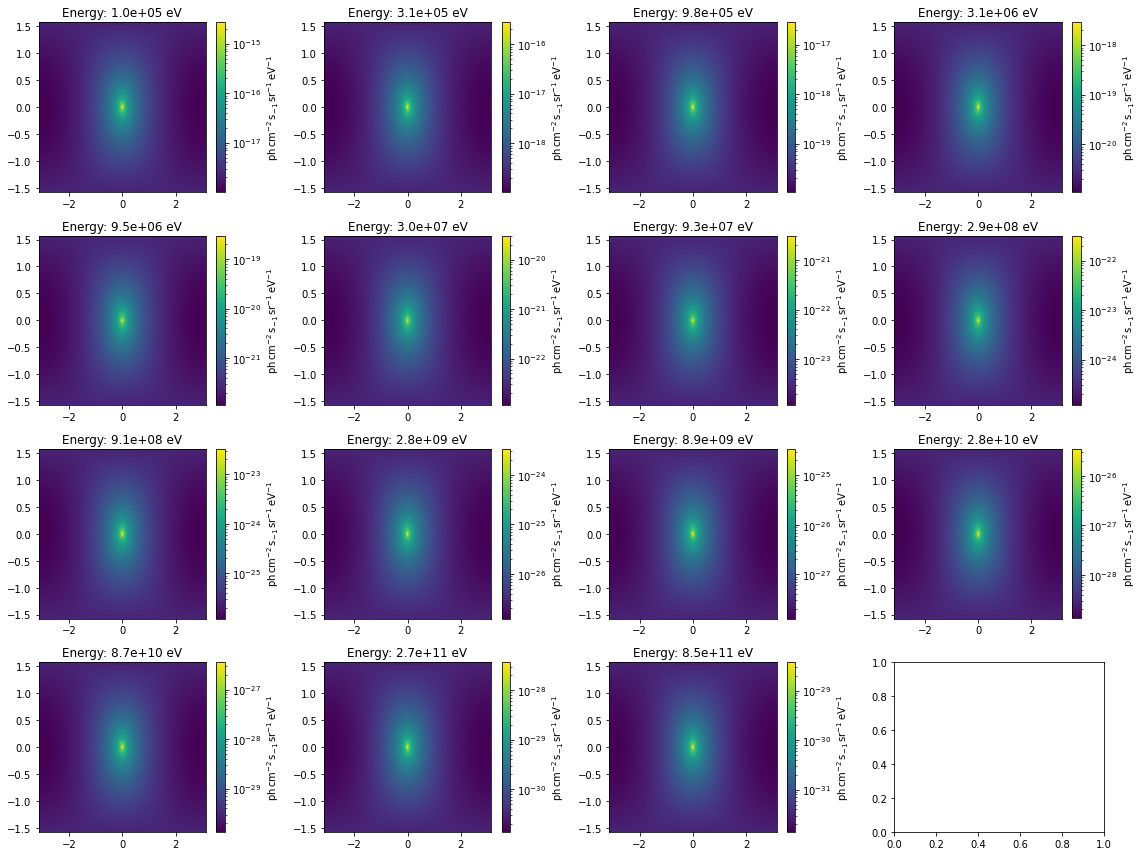

In [27]:
plt.subplots(nrows=4,ncols=4,figsize=(16,12))

nn = 1
for i in range(0,n_e,int(100/14)):
    
    plt.subplot(4,4,nn)
    plt.pcolormesh(PHI_ARRg,THETA_ARRg,nfw_images_energy[i,:,:],norm=colors.LogNorm())
    plt.title('Energy: {0:1.1e} eV'.format(energies[i].value))
    plt.colorbar(label=r'$\mathrm{ph\,cm^{-2}\,s_{-1}\,sr^{-1}\,eV^{-1}}$')
    nn += 1
    
plt.tight_layout()

<h3>Of course, always the same image, but with different colorbar according to $dN/dE(E)$.<br>
    Can also do $\nu F_\nu$ spectrum again:</h3>

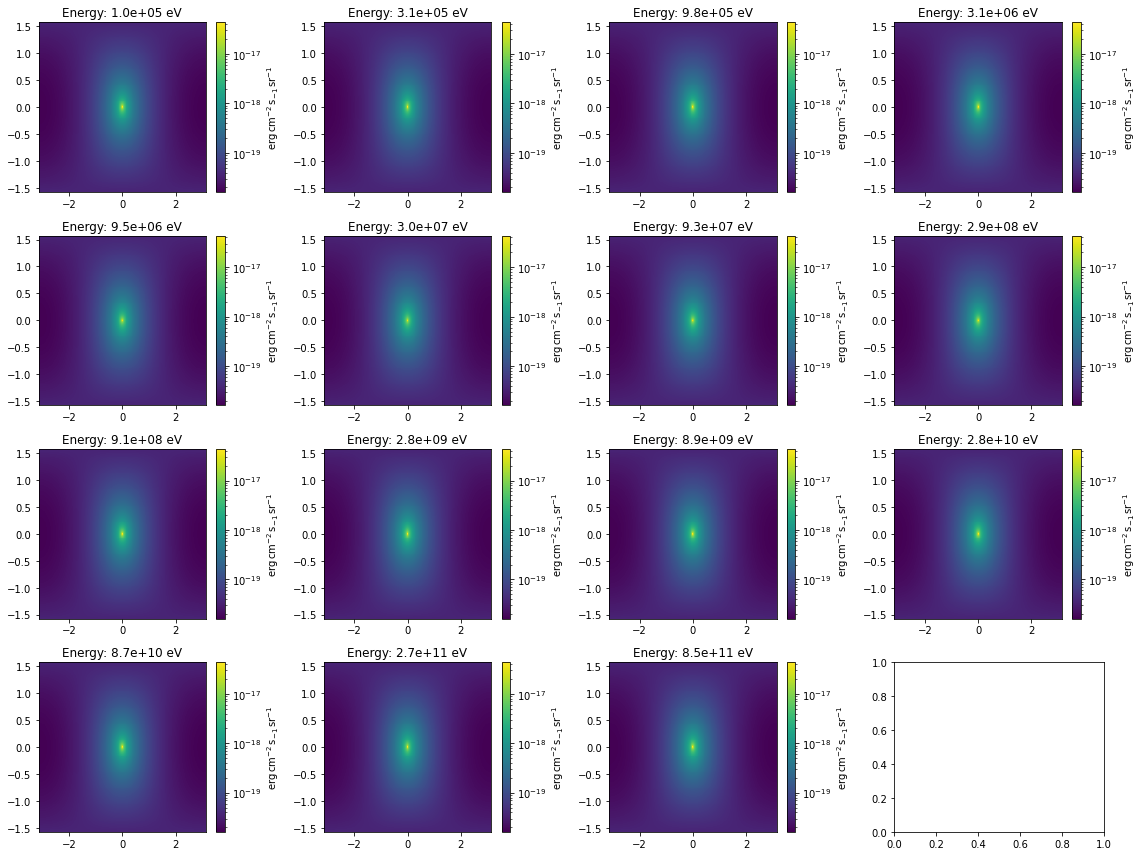

In [28]:
plt.subplots(nrows=4,ncols=4,figsize=(16,12))

nn = 1
for i in range(0,n_e,int(100/14)):
    
    plt.subplot(4,4,nn)
    plt.pcolormesh(PHI_ARRg,THETA_ARRg,(nfw_images_energy[i,:,:]*energies[i]**2).to(u.erg/u.cm**2/u.s/u.sr),norm=colors.LogNorm())
    plt.title('Energy: {0:1.1e} eV'.format(energies[i].value))
    plt.colorbar(label=r'$\mathrm{erg\,cm^{-2}\,s_{-1}\,sr^{-1}}$')
    nn += 1
    
plt.tight_layout()

<h3>And total fluxes in each image:</h3>

In [29]:
# empty array with correct units
spec = np.zeros(n_e)/u.cm**2/u.s/u.eV

In [30]:
for i in range(n_e):
    spec[i] = np.sum(nfw_images_energy[i,:,:]*dOmega*u.sr)

Text(0, 0.5, 'dN/(dE dA dt) [ph/cm2/s/eV]')

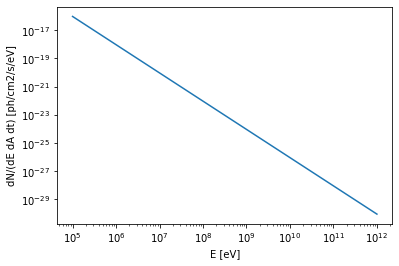

In [31]:
plt.loglog(energies,spec)
plt.xlabel('E [eV]')
plt.ylabel('dN/(dE dA dt) [ph/cm2/s/eV]')

Text(0, 0.5, 'E^2 dN/(dE dA dt) [erg/cm2/s]')

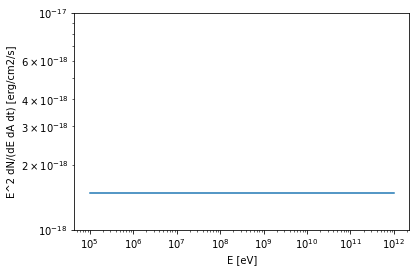

In [32]:
plt.loglog(energies,(spec*energies**2).to(u.erg/u.cm**2/u.s))
plt.xlabel('E [eV]')
plt.ylabel('E^2 dN/(dE dA dt) [erg/cm2/s]')

<h3>'Flux' in different regions of the sky:</h3>

In [33]:
# all angular units in deg
region_flux = nfw.flux_in_circular_region(phi_center=50,theta_center=0,radius=5)
region_flux

7.530266804195595e-06

In [34]:
# total 'flux'
total_flux = nfw.flux
total_flux

0.004143420706549371

<h3>Thus, your resulting spectrum can be scaled by region_flux/total_flux and you have the contribution of the NFW halo of Milky Way in a particular direction</h3>

<h1>GALPROP part:</h1>

In [35]:
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy.coordinates import Galactic
from astropy_healpix import HEALPix
from astropy import units as u
from astropy import wcs

<h3>The important files form a GALPROP run are:<br><br>
    bremss_healpix_57_example.gz: Bremsstrahlung<br>
    free_free_healpix_57_example.gz: Free-free emission (electron electron bremsstrahlung)<br>
    ics_isotropic_healpix_57_example.gz: Inverse Compton scattering (total)<br>
    pi0_decay_healpix_57_example.gz: Pion decay<br>
    synchrotron_healpix_57_example.gz: Synchrotron emission<br><br>
    I use the example of ICS to show the procedure and how to deal with the file, etc.</h3>    

In [36]:
path = 'example/'

In [37]:
ics = fits.open(path+"ics_isotropic_healpix_57_example.gz")

In [38]:
ee = ics['ENERGIES'].data['Energy'] * u.MeV

In [39]:
ee # in MeV

<Quantity [1.000000e-01, 2.000000e-01, 4.000000e-01, 8.000000e-01,
           1.600000e+00, 3.200000e+00, 6.400000e+00, 1.280000e+01,
           2.560000e+01, 5.120000e+01, 1.024000e+02, 2.048000e+02,
           4.096000e+02, 8.192000e+02, 1.638400e+03, 3.276800e+03,
           6.553600e+03, 1.310720e+04, 2.621440e+04, 5.242880e+04,
           1.048576e+05, 2.097152e+05, 4.194304e+05, 8.388608e+05] MeV>

In [40]:
n_ee = len(ee)
n_ee

24

In [41]:
nside = ics['SKYMAP'].header['NSIDE']
order = ics['SKYMAP'].header['ORDERING']  
hp = HEALPix(nside=nside, order=order, frame=Galactic()) 

In [42]:
coords = SkyCoord(PHI_ARR.ravel()*180/np.pi, THETA_ARR.ravel()*180/np.pi, frame=Galactic(), unit='deg')

In [43]:
# converting healpix map to rectangular map similar to the case above
# the bin number gives you the energy index
# Bin0 = 0.1 MeV
# Bin1 = 0.2 MeV
# ...
# Bin23 = 8.388608e5 MeV

fluxes = ics['SKYMAP'].data['Bin4'] # 1.6 MeV
flux_map = hp.interpolate_bilinear_skycoord(coords, fluxes)
flux_map = flux_map.reshape((THETA_ARR.shape[0], PHI_ARR.shape[1]))
# the GALPROP images have units of ph/cm2/s/sr/MeV

In [44]:
# creating empty los object to get all the functinality
ics_los = los.Empty(pixelsize=pixelsize,frame='G',observer=10)

In [45]:
# set the empty image to the new flux map
ics_los._image = flux_map

In [46]:
# total flux
ics_total_flux = ics_los.flux
ics_total_flux
# that flux is now in units of ph/cm2/s/MeV

0.0007241154680340604

In [47]:
ics_region_flux = ics_los.flux_in_circular_region(phi_center=50,theta_center=0,radius=5)
ics_region_flux

6.965260063288566e-06

In [48]:
# creating ics image array
ics_image_array = np.zeros((n_ee,n_theta,n_phi)) / u.cm**2 / u.s / u.MeV / u.sr

for i in range(n_ee):
    idx = '{0}'.format(i)
    fluxes = ics['SKYMAP'].data['Bin'+idx]
    flux_map = hp.interpolate_bilinear_skycoord(coords, fluxes)
    flux_map = flux_map.reshape((THETA_ARR.shape[0], PHI_ARR.shape[1]))
    ics_image_array[i,:,:] = flux_map / u.cm**2 / u.s / u.MeV / u.sr

<h3>Now you have the same structure as before and can to the same things...</h3>

In [49]:
# empty array with correct units
spec_ics = np.zeros(n_ee)/u.cm**2/u.s/u.eV

for i in range(n_ee):
    spec_ics[i] = np.sum(ics_image_array[i,:,:]*dOmega*u.sr)

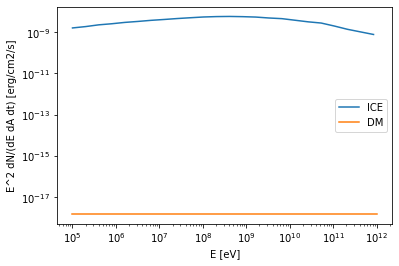

In [50]:
plt.loglog(ee.to(u.eV),(spec_ics*ee**2).to(u.erg/u.cm**2/u.s),label='ICE')
plt.loglog(energies,(spec*energies**2).to(u.erg/u.cm**2/u.s),label='DM')
plt.xlabel('E [eV]')
plt.ylabel('E^2 dN/(dE dA dt) [erg/cm2/s]')
plt.legend()

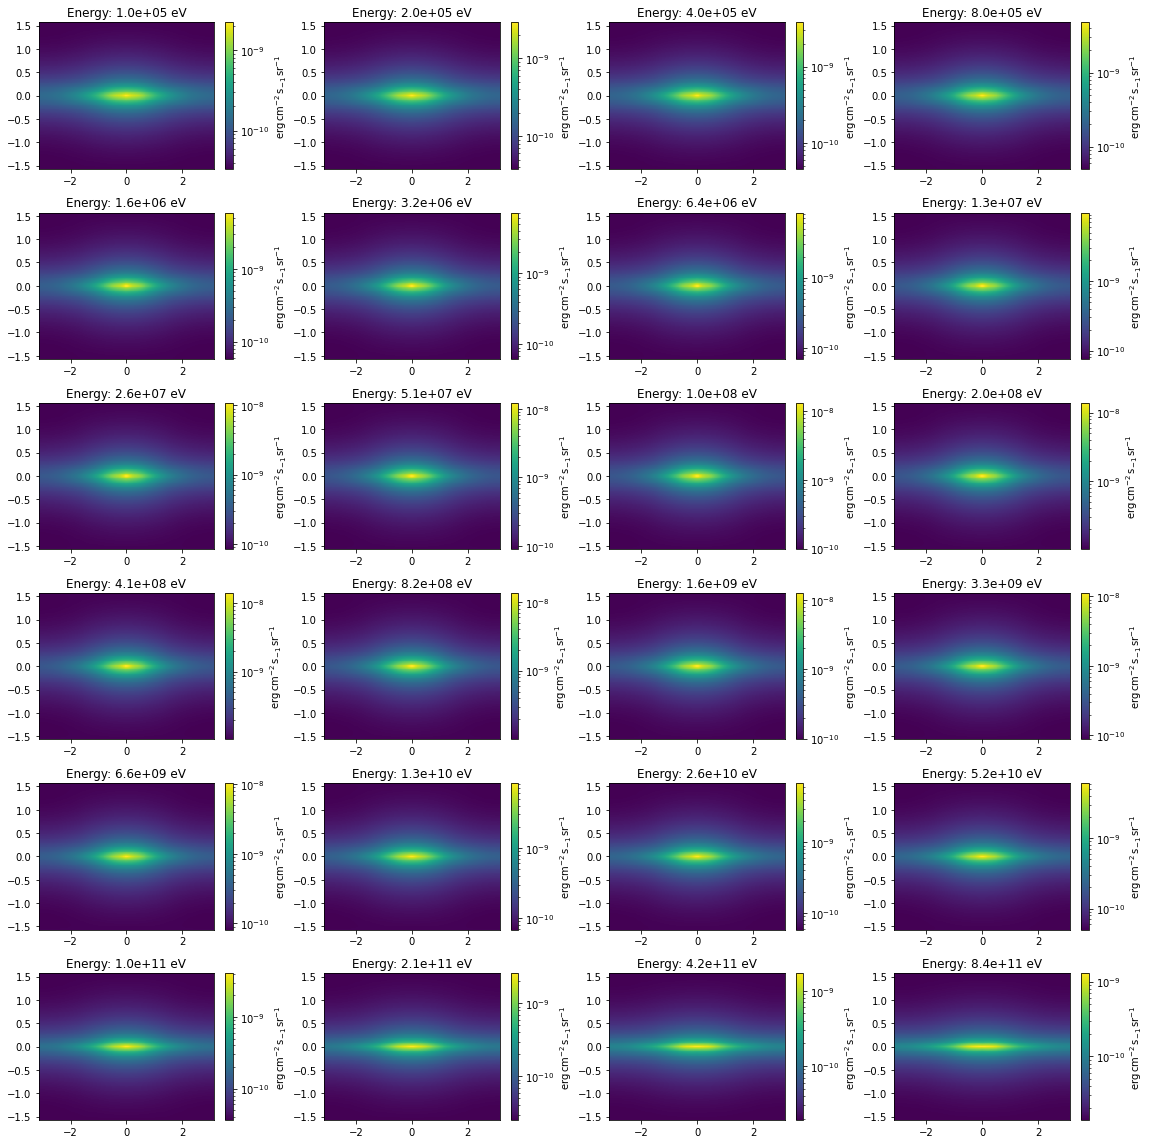

In [51]:
plt.subplots(nrows=6,ncols=4,figsize=(16,16))

nn = 1
for i in range(0,n_ee,1):
    
    plt.subplot(6,4,nn)
    plt.pcolormesh(PHI_ARRg,THETA_ARRg,(ics_image_array[i,:,:]*ee[i]**2).to(u.erg/u.cm**2/u.s/u.sr),norm=colors.LogNorm())
    plt.title('Energy: {0:1.1e} eV'.format(ee[i].value*1e6))
    plt.colorbar(label=r'$\mathrm{erg\,cm^{-2}\,s_{-1}\,sr^{-1}}$')
    nn += 1
    
plt.tight_layout()